In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error
import seaborn as sns
import missingno as msno
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

In [21]:
# === 1. Daten einlesen und vorbereiten ===
air = pd.read_csv("air.csv")

# Prüfen, ob "From Date" existiert oder schon Index ist
if 'From Date' in air.columns:
    air['From Date'] = pd.to_datetime(air['From Date'])
    air.set_index('From Date', inplace=True)
else:
    air.index = pd.to_datetime(air.index)

air = air.rename(columns={"PM2.5 (ug/m3)": "y"})
air['y'].fillna(method='ffill', inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_19160\1294356785.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  air['y'].fillna(method='ffill', inplace=True)


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and 

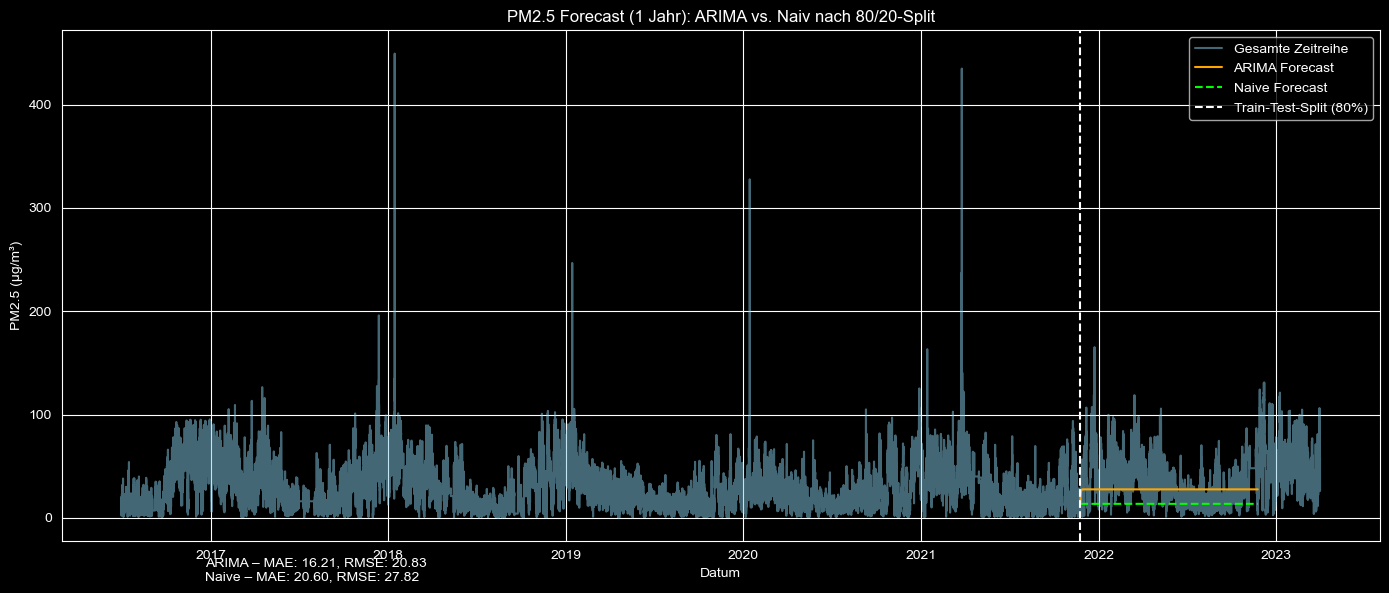

In [22]:
total_len = len(air)
split_idx = int(total_len * 0.8)
train = air.iloc[:split_idx].copy()

forecast_steps = 8760
forecast_index = pd.date_range(start=air.index[split_idx], periods=forecast_steps, freq='H')

# === 3. ARIMA(1,0,0) Modell ===
model = ARIMA(train['y'], order=(1,0,0))
model_fit = model.fit()
forecast_arima = pd.Series(model_fit.forecast(steps=forecast_steps), index=forecast_index)

# === 4. Naiver Forecast ===
last_val = train['y'].iloc[-1]
forecast_naive = pd.Series([last_val] * forecast_steps, index=forecast_index)

# === 5. Testdaten für Vergleich (sofern vorhanden) ===
if forecast_index[-1] <= air.index[-1]:
    y_test = air.loc[forecast_index[0]:forecast_index[-1], 'y']
    mae_arima = mean_absolute_error(y_test, forecast_arima)
    rmse_arima = mean_squared_error(y_test, forecast_arima, squared=False)
    mae_naive = mean_absolute_error(y_test, forecast_naive)
    rmse_naive = mean_squared_error(y_test, forecast_naive, squared=False)
else:
    y_test = None
    mae_arima = rmse_arima = mae_naive = rmse_naive = np.nan

# === 6. Plot ===
plt.style.use("dark_background")
plt.figure(figsize=(14,6))

# Originaldaten
plt.plot(air['y'], label='Gesamte Zeitreihe', color='skyblue', alpha=0.5)

# Forecasts
plt.plot(forecast_arima, label='ARIMA Forecast', color='orange')
plt.plot(forecast_naive, label='Naive Forecast', color='lime', linestyle='--')

# Split-Linie
plt.axvline(air.index[split_idx], color='white', linestyle='--', label='Train-Test-Split (80%)')

# Titel und Achsen
plt.title("PM2.5 Forecast (1 Jahr): ARIMA vs. Naiv nach 80/20-Split")
plt.xlabel("Datum")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()

# Fehlertext anzeigen
if y_test is not None:
    error_text = (
        f"ARIMA – MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}\n"
        f"Naive – MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}"
    )
    plt.figtext(0.15, 0.02, error_text, fontsize=10, ha='left', va='bottom', color='white')

plt.tight_layout()
plt.show()

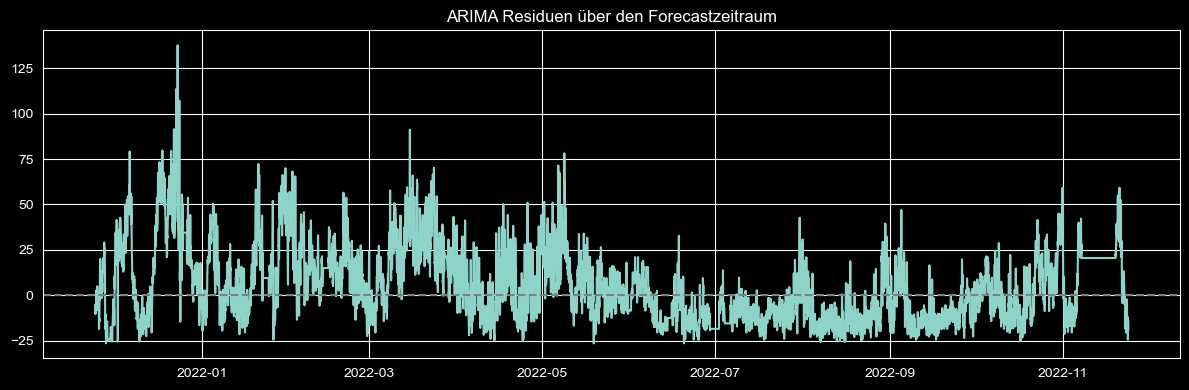

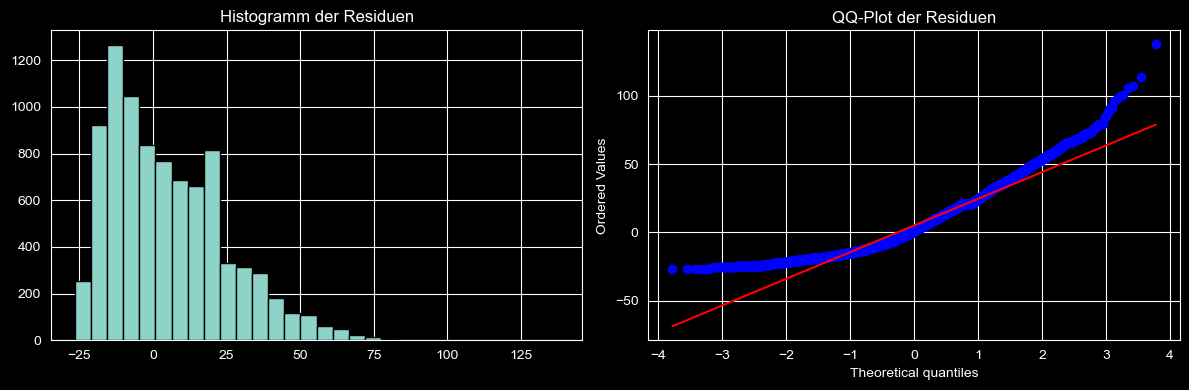

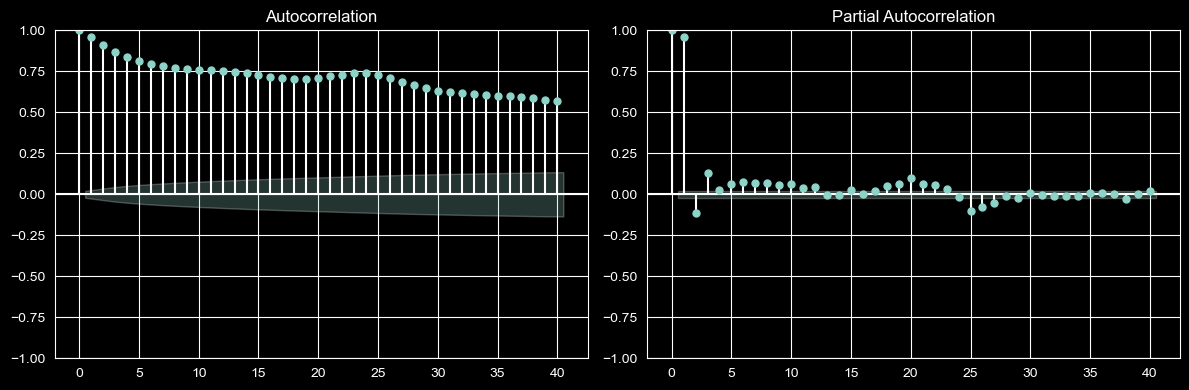

Ljung-Box-Test (ARIMA Residuen):
          lb_stat  lb_pvalue
10   60086.680487        0.0
20  106523.052247        0.0
40  180972.912715        0.0
Shapiro-Wilk-Test: W = 0.9372, p = 0.0000


C:\Users\HP\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
# === 1. Residuen berechnen ===
residuals = y_test - forecast_arima

# === 2. Zeitreihenplot ===
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("ARIMA Residuen über den Forecastzeitraum")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# === 3. Histogramm + QQ-Plot ===
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogramm der Residuen")

plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot der Residuen")
plt.tight_layout()
plt.show()

# === 4. ACF & PACF ===
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(residuals, lags=40, ax=ax[0])
plot_pacf(residuals, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

# === 5. Ljung-Box-Test ===
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 40], return_df=True)
print("Ljung-Box-Test (ARIMA Residuen):")
print(lb_test)

# === 6. Shapiro-Wilk-Test (Normalverteilung) ===
w, p = stats.shapiro(residuals)
print(f"Shapiro-Wilk-Test: W = {w:.4f}, p = {p:.4f}")